# Setup

In [1]:
# import necessary libraries and files
import sys

sys.path.append('../src/data')
from make_dataset import *

sys.path.append('../src/visualization')
from visualize import *

# Data Preprocessing

In [2]:
filepath1 = '../data/raw/user1/'
df1, schema1, time_df1 = get_data(filepath1, read_from_notebook=True, out_schema=True)
all_time_df1 = save_time_measurement(time_df1, filepath1, saved=False)

filepath2 = '../data/raw/user2/'
df2, schema2, time_df2 = get_data(filepath2, read_from_notebook=True, out_schema=True)
all_time_df2 = save_time_measurement(time_df2, filepath2, saved=False)

# Exploratory Data Analysis (EDA)

## EDA for User 1

### Basic Statistics

In [4]:
basic_stats(df1, schema1, all_time_df1)

========================================EDA========================================
Schema
     ID_INPUT           INPUT_NAME                     INPUT_DESCRIPTION
0          0   FOREGROUND-WIND(0)             Foreground Window Root ID
1          1   FOREGROUND-WIND(1)          Foreground Window Process ID
2          2   FOREGROUND-WIND(2)           Foreground Window Thread ID
3          3   FOREGROUND-WIND(3)                Foreground Window Name
4          4   FOREGROUND-WIND(4)          Foreground Window Image Name
5          5   FOREGROUND-WIND(5)          Foreground Window Class Name
6          6   FOREGROUND-WIND(6)        Window Upper Left X Coordinate
7          7   FOREGROUND-WIND(7)       Window Lower Right X Coordinate
8          8   FOREGROUND-WIND(8)        Window Upper Left Y Coordinate
9          9   FOREGROUND-WIND(9)       Window Lower Right Y Coordinate
10        10  FOREGROUND-WIND(10)       Check if the App is Hung or Not
11        11  FOREGROUND-WIND(11)  Check if 

### Explore Time Usage

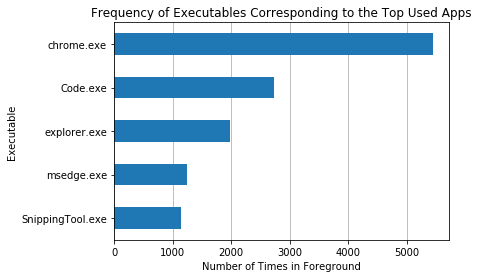

Apps vs Time Used (in secs) During a Week


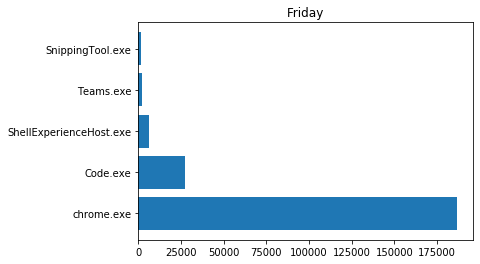

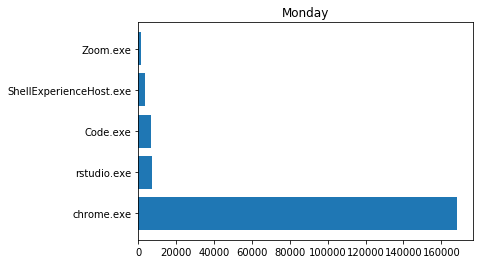

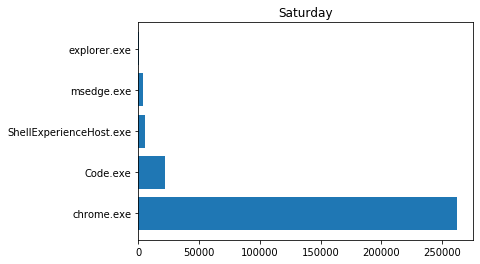

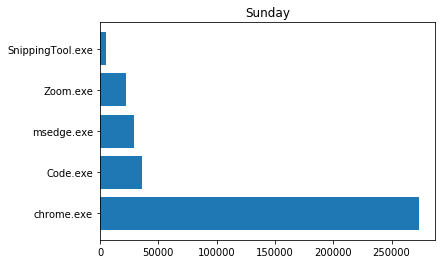

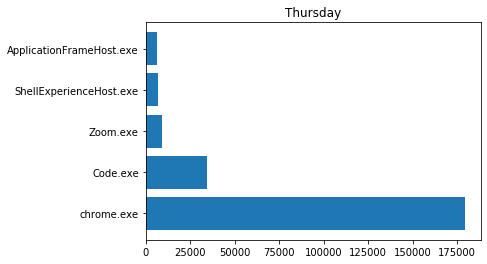

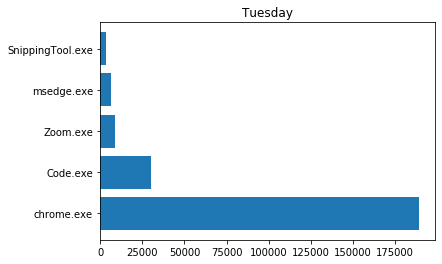

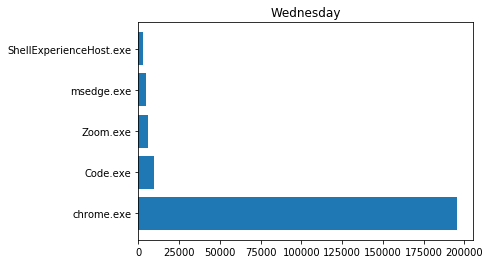

Plot top 5 apps with the most time spent on for the whole DataFrame


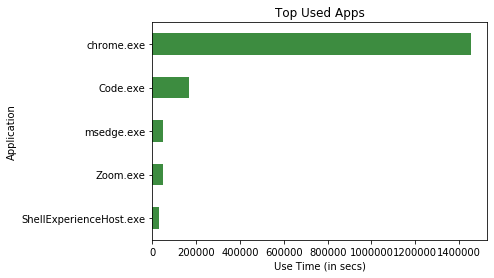

In [5]:
some_bar_charts(df1, all_time_df1)

Apps vs Time Used


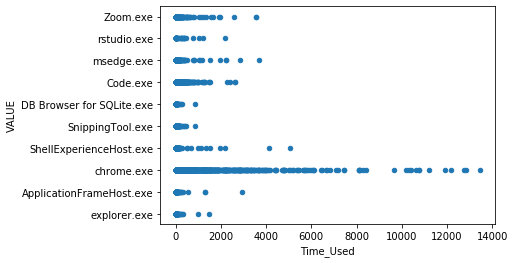

In [6]:
scatter_plot(df1, all_time_df1)

## EDA for User 2

### Basic Statistics

In [7]:
basic_stats(df2, schema2, all_time_df2)

========================================EDA========================================
Schema
     ID_INPUT           INPUT_NAME                     INPUT_DESCRIPTION
0          0   FOREGROUND-WIND(0)             Foreground Window Root ID
1          1   FOREGROUND-WIND(1)          Foreground Window Process ID
2          2   FOREGROUND-WIND(2)           Foreground Window Thread ID
3          3   FOREGROUND-WIND(3)                Foreground Window Name
4          4   FOREGROUND-WIND(4)          Foreground Window Image Name
5          5   FOREGROUND-WIND(5)          Foreground Window Class Name
6          6   FOREGROUND-WIND(6)        Window Upper Left X Coordinate
7          7   FOREGROUND-WIND(7)       Window Lower Right X Coordinate
8          8   FOREGROUND-WIND(8)        Window Upper Left Y Coordinate
9          9   FOREGROUND-WIND(9)       Window Lower Right Y Coordinate
10        10  FOREGROUND-WIND(10)       Check if the App is Hung or Not
11        11  FOREGROUND-WIND(11)  Check if 

### Explore Time Usage

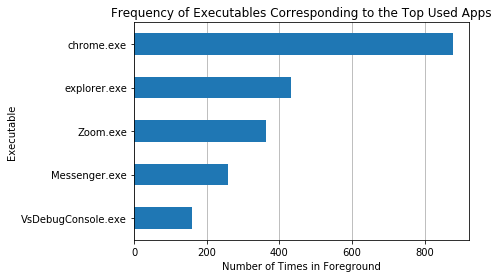

Apps vs Time Used (in secs) During a Week


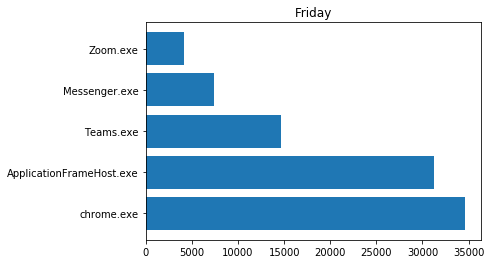

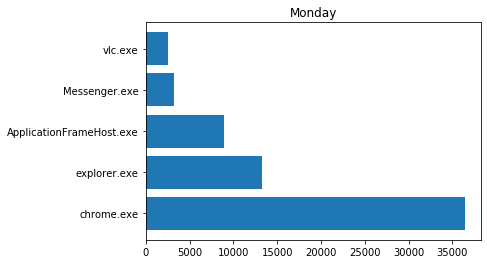

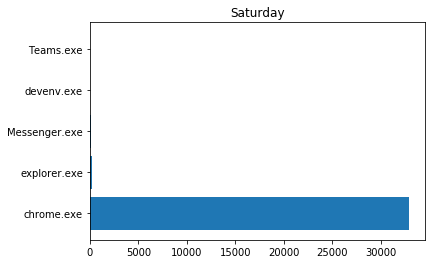

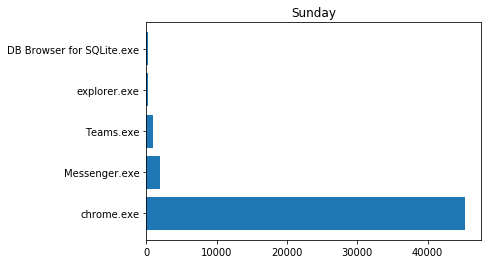

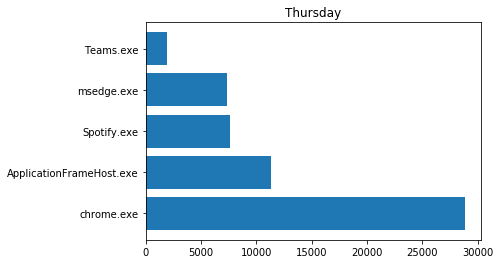

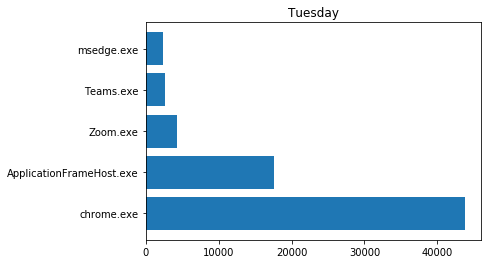

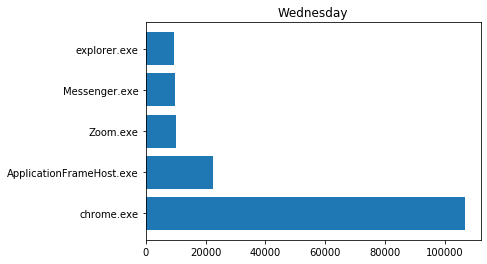

Plot top 5 apps with the most time spent on for the whole DataFrame


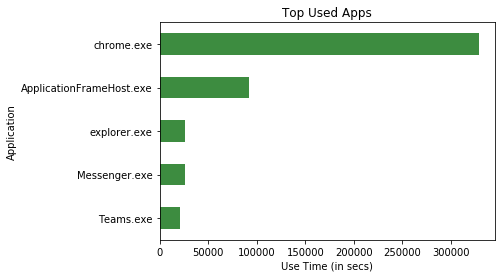

In [8]:
some_bar_charts(df2, all_time_df2)

Apps vs Time Used


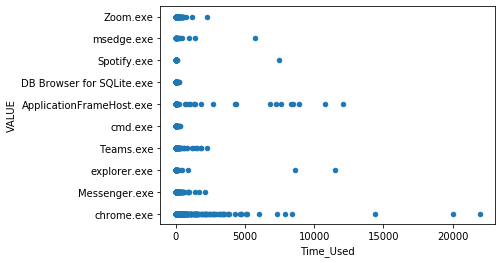

In [9]:
scatter_plot(df2, all_time_df2)